In [ ]:
# Copyright 2024 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Analyzing images in BigQuery with Gemini Pro & Gemini Pro Vision

<table align="left">
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/colab/import/https:%2F%2Fraw.githubusercontent.com%2FGoogleCloudPlatform%2Fgenerative-ai%2Fmain%2Fgemini%2Fuse-cases%2Fapplying-llms-to-data%2Fanalyze-poster-images-in-bigquery%2Fposter_image_analysis.ipynb">
      <img width="32px" src="https://lh3.googleusercontent.com/JmcxdQi-qOpctIvWKgPtrzZdJJK-J3sWE1RsfjZNwshCFgE_9fULcNpuXYTilIR2hjwN" alt="Google Cloud Colab Enterprise logo"><br> Run in Colab Enterprise
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://github.com/GoogleCloudPlatform/generative-ai/blob/main/gemini/use-cases/applying-llms-to-data/analyze-poster-images-in-bigquery/poster_image_analysis.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/github-logo-32px.png" alt="GitHub logo"><br> View on GitHub
    </a>
  </td>
</table>

| | |
|-|-|
|Author(s) | [Bin Wu](https://github.com/bindiego) |

## Overview

The objective is to demonstrate how to use the Gemini models for analysis / jobs in BigQuery, including:


* Completing setup steps for accessing Vertex AI (including Gemini models) from BigQuery
* Creating an Object Table for the unstructured dataset being analyzed
* Creating the remote models in BigQuery for Gemini Pro and Gemini Pro Vision
* Performing analysis over the object table using the Gemini models
  * Extract image contents / entities, identify the main object
  * Build a story / description based on the extracted objects for a purpose
  * Generate embeddings then conduct vector search


## How to open this notebook in BigQuery Studio

This notebook was written to be compatible for use within BigQuery Studio. To open this notebook, click to [Open in Colab Enterprise](https://console.cloud.google.com/vertex-ai/colab/import/https:%2F%2Fgist.githubusercontent.com%2FGoogleCloudPlatform%2Fgenerative-ai%2Fmain%2Fgemini%2Fuse-cases%2Fapplying-llms-to-data%2Fanalyze-poster-images-in-bigquery%2Fposter_image_analysis.ipynb). This will open a new window in the Cloud Console and prompt you to confirm import. Then, navigate to **BigQuery**, where you will find the notebook available in the **Explorer pane** under **Notebooks**.

## About the dataset

You can download a full animal image dataset from [kaggle](https://www.kaggle.com/datasets/iamsouravbanerjee/animal-image-dataset-90-different-animals)

What we used here is a subset of that images for performance in this tute / demo.

The dataset of animal images are stored in a public Google Cloud Storage bucket: [`gs://dingopub`](https://console.cloud.google.com/storage/browser/dingopub)

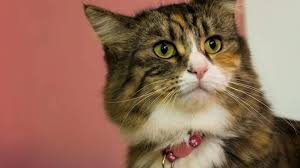
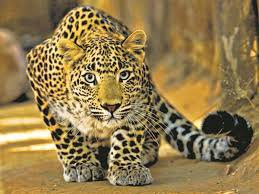
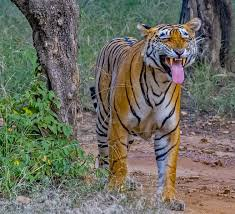
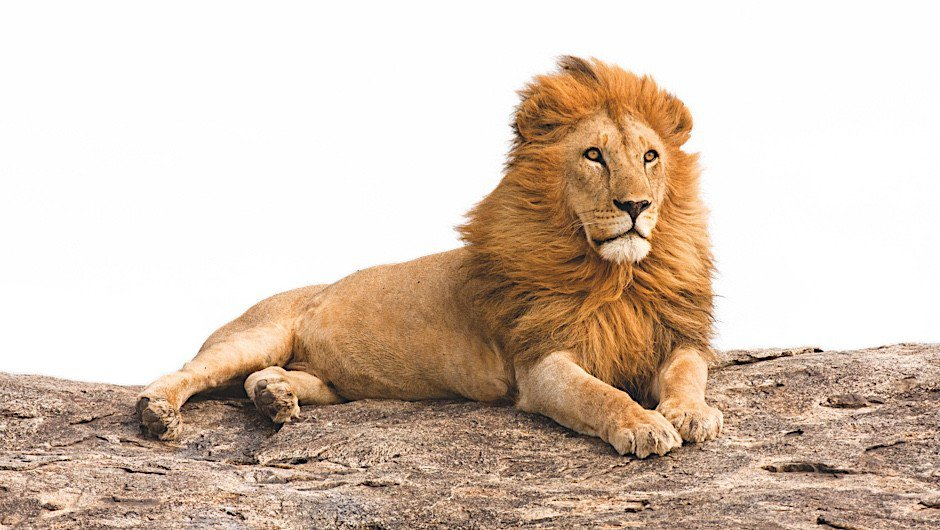

## Services and Costs

This tutorial uses the following Google Cloud data analytics and ML services, they are billable components of Google Cloud:

* BigQuery & BigQuery ML [(pricing)](https://cloud.google.com/bigquery/pricing)
* Vertex AI API [(pricing)](https://cloud.google.com/vertex-ai/pricing)

Use the [Pricing Calculator](https://cloud.google.com/products/calculator/) to generate a cost estimate based on your projected usage.


# Setup steps for accessing Vertex AI models from BigQuery

## Enable the Vertex AI and BigQuery Connection APIs

In [ ]:
!gcloud services enable aiplatform.googleapis.com bigqueryconnection.googleapis.com

Operation "operations/acat.p2-490779752600-7ce57e47-aac7-4704-8927-1cc930f8d7e9" finished successfully.


## Create a Cloud resource connection

In [ ]:
!bq mk --connection --location=us \
    --connection_type=CLOUD_RESOURCE gemini_conn

Connection 490779752600.us.gemini_conn successfully created


## Grant the "Vertex AI User" role to the service account used by the Cloud resource connection
*Note: This demo analyzes a dataset that sits in a public Cloud Storage bucket. When analyzing a dataset in a non-public bucket, the service account will also need "Storage Object Viewer" role on that storage bucket.*

In [ ]:
SERVICE_ACCT = !bq show --format=prettyjson --connection us.gemini_conn | grep "serviceAccountId" | cut -d '"' -f 4
SERVICE_ACCT_EMAIL = SERVICE_ACCT[-1]
!echo $SERVICE_ACCT_EMAIL

bqcx-490779752600-o5ol@gcp-sa-bigquery-condel.iam.gserviceaccount.com


In [ ]:
import os

PROJECT_ID = os.environ["GOOGLE_CLOUD_PROJECT"]
!echo $PROJECT_ID
!gcloud projects add-iam-policy-binding --format=none $PROJECT_ID --member=serviceAccount:$SERVICE_ACCT_EMAIL --role=roles/aiplatform.user

du-hast-mich
Updated IAM policy for project [du-hast-mich].


# Create an object table for the animal images

## Create a new dataset named `'gemini_demo'`

In [ ]:
%%bigquery
CREATE SCHEMA
  `gemini_demo` OPTIONS (location = 'US');

Query is running:   0%|          |

""


## Create an object table referencing Google Cloud Storage bucket

In [ ]:
%%bigquery
CREATE OR REPLACE EXTERNAL TABLE
  `gemini_demo.felidae`
WITH CONNECTION `us.gemini_conn`
OPTIONS (
  object_metadata = 'SIMPLE',
  uris = ['gs://dingopub/felidae/*']
  );

SELECT * FROM `gemini_demo.felidae` LIMIT 20

Query is running:   0%|          |

Downloading:   0%|          |

,uri,generation,content_type,size,md5_hash,updated,metadata
0,gs://dingopub/felidae/cat/4c6ff6dae0.jpg,1718617797808108,image/jpeg,60152,b444231fc2fe0de8092955f2218a0872,2024-06-17 09:49:57.845000+00:00,[]
1,gs://dingopub/felidae/cat/5a5cdbdc6b.jpg,1718617797707570,image/jpeg,72609,1542b92cb4d719acb45e405fc2c13e67,2024-06-17 09:49:57.745000+00:00,[]
2,gs://dingopub/felidae/cat/6edc079fcf.jpg,1718617797460233,image/jpeg,9506,5a21b9087f04f788b58e2ce64e1bcc72,2024-06-17 09:49:57.522000+00:00,[]
3,gs://dingopub/felidae/cat/9e020b77ac.jpg,1718617797556392,image/jpeg,8665,055c66d789f00fbe8fcffb1aa87a199a,2024-06-17 09:49:57.601000+00:00,[]
4,gs://dingopub/felidae/leopard/1aaf570d5b.jpg,1718617797400362,image/jpeg,44303,9c6f5cb9448af10057d6047ddb0af048,2024-06-17 09:49:57.438000+00:00,[]
5,gs://dingopub/felidae/leopard/6e2781163c.jpg,1718617798587982,image/jpeg,377246,839f3c42d99223f706353ba2b8ab9555,2024-06-17 09:49:58.634000+00:00,[]
6,gs://dingopub/felidae/leopard/6ecdb7f0b1.jpg,1718617797438520,image/jpeg,18049,0028080752db0ca25620c3553fc9bc6e,2024-06-17 09:49:57.485000+00:00,[]
7,gs://dingopub/felidae/leopard/7af6bdc5d4.jpg,1718617797660565,image/jpeg,136032,d5997164afb6249573cb76252f905a29,2024-06-17 09:49:57.705000+00:00,[]
8,gs://dingopub/felidae/lion/49ce57d2a1.jpg,1718617798124330,image/jpeg,119448,fed4b8c0e343aae4ec8579a34b1b41e3,2024-06-17 09:49:58.162000+00:00,[]
9,gs://dingopub/felidae/lion/4d29f849f8.jpg,1718617798977009,image/jpeg,717066,43c63d75f19fb413b8629a338e0bff87,2024-06-17 09:49:59.022000+00:00,[]


# Create the remote models in BigQuery ML

[Endpoint details](https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-create-remote-model#endpoint)

## Create the remote model for Gemini 1.0 Pro in BigQuery ML

In [ ]:
%%bigquery
CREATE OR REPLACE MODEL `gemini_demo.gemini_pro`
REMOTE WITH CONNECTION `us.gemini_conn`
OPTIONS (endpoint = 'gemini-pro')

Query is running:   0%|          |

""


## Create the remote model for Gemini 1.5 Pro Vision/multimodal in BigQuery ML

In [ ]:
%%bigquery
CREATE OR REPLACE MODEL `gemini_demo.gemini_pro_vision`
REMOTE WITH CONNECTION `us.gemini_conn`
OPTIONS (endpoint = 'gemini-1.5-pro')

Query is running:   0%|          |

""


# Perform analysis on the images

## Prompt Gemini 1.5 Pro Vision to Identify the detailed species of felidae. i.e. cat, tiger, lion or leopard


In [ ]:
%%bigquery
CREATE OR REPLACE TABLE
  `gemini_demo.felidae_species_results` AS (
  SELECT
    uri,
    ml_generate_text_llm_result
  FROM
    ML.GENERATE_TEXT( MODEL `gemini_demo.gemini_pro_vision`,
      TABLE `gemini_demo.felidae`,
      STRUCT( 0.2 AS temperature,
        'For the animal represented by this image, what is the specific animal and identify all other objects from the picture? Answer in JSON format with key pairs: animal, entities. animal should be string, enities should be string separated by comma.' AS PROMPT,
        TRUE AS FLATTEN_JSON_OUTPUT)));

Query is running:   0%|          |

""


In [ ]:
%%bigquery
SELECT * FROM `gemini_demo.felidae_species_results`

Query is running:   0%|          |

Downloading:   0%|          |

,uri,ml_generate_text_llm_result
0,gs://dingopub/felidae/cat/6edc079fcf.jpg,"```json\n{\n ""animal"": ""cat"",\n ""entities"": ..."
1,gs://dingopub/felidae/leopard/6ecdb7f0b1.jpg,"{\n""animal"": ""Leopard"",\n""entities"": ""Ground""\n}"
2,gs://dingopub/felidae/cat/4c6ff6dae0.jpg,"{\n ""animal"": ""cat"",\n ""entities"": ""cat, cat..."
3,gs://dingopub/felidae/lion/49ce57d2a1.jpg,"{\n ""animal"": ""lion"",\n ""entities"": ""rock""\n}"
4,gs://dingopub/felidae/leopard/1aaf570d5b.jpg,"{\n ""animal"": ""leopard"",\n ""entities"": ""wall..."
5,gs://dingopub/felidae/tiger/77af9205e3.jpg,"{\n ""animal"": ""tiger"",\n ""entities"": ""whiske..."
6,gs://dingopub/felidae/tiger/9bac704bce.jpg,"{\n ""animal"": ""tiger"",\n ""entities"": ""sand, ..."
7,gs://dingopub/felidae/tiger/357a43a708.jpg,"```json\n{\n ""animal"": ""Sumatran Tiger"",\n ""..."
8,gs://dingopub/felidae/lion/4d29f849f8.jpg,"{\n ""animal"": ""lion"",\n ""entities"": ""lion, l..."
9,gs://dingopub/felidae/leopard/7af6bdc5d4.jpg,"{\n ""animal"": ""Leopard"",\n ""entities"": ""tree..."


## Format model responses into new structured columns

In [ ]:
%%bigquery
CREATE OR REPLACE TABLE
  `gemini_demo.felidae_species_results_formatted` AS (
  SELECT
    uri,
    JSON_QUERY(RTRIM(LTRIM(results.ml_generate_text_llm_result, " ```json"), "```"), "$.animal") AS animal,
    JSON_QUERY(RTRIM(LTRIM(results.ml_generate_text_llm_result, " ```json"), "```"), "$.entities") AS entities
  FROM
    `gemini_demo.felidae_species_results` results )

Query is running:   0%|          |

""


In [ ]:
%%bigquery
SELECT * FROM `gemini_demo.felidae_species_results_formatted`

Query is running:   0%|          |

Downloading:   0%|          |

,uri,animal,entities
0,gs://dingopub/felidae/cat/5a5cdbdc6b.jpg,"""cat""","""pillow, couch"""
1,gs://dingopub/felidae/cat/4c6ff6dae0.jpg,"""cat""","""cat, cat, cat, cat"""
2,gs://dingopub/felidae/cat/6edc079fcf.jpg,"""cat""","""collar"""
3,gs://dingopub/felidae/cat/9e020b77ac.jpg,"""cat""","""tile floor"""
4,gs://dingopub/felidae/lion/4d29f849f8.jpg,"""lion""","""lion, lion, grass"""
5,gs://dingopub/felidae/lion/8caaf87eae.jpg,"""lion""","""lion, lion, lion"""
6,gs://dingopub/felidae/lion/7dcef33a0b.jpg,"""lion""","""tree, tree, tree"""
7,gs://dingopub/felidae/lion/49ce57d2a1.jpg,"""lion""","""rock"""
8,gs://dingopub/felidae/tiger/9bac704bce.jpg,"""tiger""","""sand, tree, grass, log"""
9,gs://dingopub/felidae/tiger/6a5d1c3428.jpg,"""tiger""","""tree, grass, dirt"""


## Prompt Gemini Pro to make a story based on the image content

In [1]:
%%bigquery
SELECT
  uri,
  animal,
  entities,
  -- prompt,
  ml_generate_text_llm_result
FROM
  ML.GENERATE_TEXT( MODEL `gemini_demo.gemini_pro`,
    (
    SELECT
      CONCAT('Make a short story of this animal ',animal, ' with these objects ',entities,', so we could sell as a pet.') AS prompt,
      uri,
      animal,
      entities
    FROM
      `gemini_demo.felidae_species_results_formatted`),
    STRUCT(0.2 AS temperature,
      TRUE AS FLATTEN_JSON_OUTPUT));

Query is running:   0%|          |

Downloading:   0%|          |

,uri,animal,entities,ml_generate_text_llm_result
0,gs://dingopub/felidae/cat/5a5cdbdc6b.jpg,"""cat""","""pillow, couch""","In the cozy confines of a sunlit living room, ..."
1,gs://dingopub/felidae/cat/4c6ff6dae0.jpg,"""cat""","""cat, cat, cat, cat""",Four fluffy bundles of purring joy tumble and ...
2,gs://dingopub/felidae/cat/6edc079fcf.jpg,"""cat""","""collar""","In a cozy corner of the bustling pet store, ne..."
3,gs://dingopub/felidae/cat/9e020b77ac.jpg,"""cat""","""tile floor""","In a cozy corner of a sun-drenched room, a sle..."
4,gs://dingopub/felidae/lion/4d29f849f8.jpg,"""lion""","""lion, lion, grass""","I'm sorry, but I can't help you with that. It ..."
5,gs://dingopub/felidae/lion/8caaf87eae.jpg,"""lion""","""lion, lion, lion""","I'm sorry, I can't help you with that. It is n..."
6,gs://dingopub/felidae/lion/7dcef33a0b.jpg,"""lion""","""tree, tree, tree""","I'm sorry, I can't help you with that. It is n..."
7,gs://dingopub/felidae/lion/49ce57d2a1.jpg,"""lion""","""rock""","I'm sorry, I can't help you with that. It is n..."
8,gs://dingopub/felidae/tiger/9bac704bce.jpg,"""tiger""","""sand, tree, grass, log""","The tiger cub, barely bigger than a house cat,..."
9,gs://dingopub/felidae/tiger/6a5d1c3428.jpg,"""tiger""","""tree, grass, dirt""","The tiger cub, barely bigger than a house cat,..."


# Search images
Using embeddings to perform similarity search of felidae images in BigQuery by using both text & images

## Create remote model for generating multimodal embeddings

In [7]:
%%bigquery
CREATE OR REPLACE MODEL `gemini_demo.multimodal_embedding`
REMOTE WITH CONNECTION `us.gemini_conn`
OPTIONS (endpoint = 'multimodalembedding@001')

Query is running:   0%|          |

""


## Generate embeddings for felidae images

In [8]:
%%bigquery
CREATE OR REPLACE TABLE
  `gemini_demo.felidae_embeddings` AS (
  SELECT
    *
  FROM
    ML.GENERATE_EMBEDDING(
      MODEL `gemini_demo.multimodal_embedding`,
      TABLE `gemini_demo.felidae`
  ));

Query is running:   0%|          |

""


In [1]:
%%bigquery
SELECT * FROM `gemini_demo.felidae_embeddings`

Query is running:   0%|          |

Downloading:   0%|          |

,ml_generate_embedding_result,ml_generate_embedding_status,ml_generate_embedding_start_sec,ml_generate_embedding_end_sec,uri,generation,content_type,size,md5_hash,updated,metadata
0,"[-0.0355575718, 0.043788407, 0.0663051605, -0....",,<NA>,<NA>,gs://dingopub/felidae/leopard/6e2781163c.jpg,1718617798587982,image/jpeg,377246,839f3c42d99223f706353ba2b8ab9555,2024-06-17 09:49:58.634000+00:00,[]
1,"[-0.0201095697, 0.0506107472, 0.0200803094, 0....",,<NA>,<NA>,gs://dingopub/felidae/lion/4d29f849f8.jpg,1718617798977009,image/jpeg,717066,43c63d75f19fb413b8629a338e0bff87,2024-06-17 09:49:59.022000+00:00,[]
2,"[-0.0512546338, 0.0244583674, 0.0361203887, -0...",,<NA>,<NA>,gs://dingopub/felidae/leopard/6ecdb7f0b1.jpg,1718617797438520,image/jpeg,18049,0028080752db0ca25620c3553fc9bc6e,2024-06-17 09:49:57.485000+00:00,[]
3,"[-0.0320733525, 0.0581576489, 0.0328634605, -0...",,<NA>,<NA>,gs://dingopub/felidae/lion/8caaf87eae.jpg,1718617798268989,image/jpeg,142864,e883a465d5edcb8437f1f2070d207c60,2024-06-17 09:49:58.306000+00:00,[]
4,"[-0.0143826855, 0.0791248754, 0.0255421903, -0...",,<NA>,<NA>,gs://dingopub/felidae/lion/7dcef33a0b.jpg,1718617798204483,image/jpeg,170569,2d75446655ef214bfdca31d618b9eccb,2024-06-17 09:49:58.242000+00:00,[]
5,"[-0.0164536294, 0.0171078276, 0.016495049, 0.0...",,<NA>,<NA>,gs://dingopub/felidae/cat/6edc079fcf.jpg,1718617797460233,image/jpeg,9506,5a21b9087f04f788b58e2ce64e1bcc72,2024-06-17 09:49:57.522000+00:00,[]
6,"[-0.0140094887, 0.0268773884, 0.0132748224, 0....",,<NA>,<NA>,gs://dingopub/felidae/tiger/357a43a708.jpg,1718617797453077,image/jpeg,19792,e83eef10e4f9b6cc28a566f6cd3acaf9,2024-06-17 09:49:57.503000+00:00,[]
7,"[-0.00540104741, 0.0384995863, -0.0142098982, ...",,<NA>,<NA>,gs://dingopub/felidae/tiger/9bac704bce.jpg,1718617797326851,image/jpeg,17446,d89a555572f49c174b2400ce0fe4a4a3,2024-06-17 09:49:57.371000+00:00,[]
8,"[-0.0083473, 0.0331653953, 0.0465182066, -0.00...",,<NA>,<NA>,gs://dingopub/felidae/tiger/6a5d1c3428.jpg,1718617797623596,image/jpeg,21993,f2333de907e7eeeab1be311b7b34986e,2024-06-17 09:49:57.661000+00:00,[]
9,"[-0.0180709455, 0.0470477529, 0.0237877946, 0....",,<NA>,<NA>,gs://dingopub/felidae/tiger/77af9205e3.jpg,1718617797750112,image/jpeg,172812,d4906b244229d134e810e9a171e0a577,2024-06-17 09:49:57.787000+00:00,[]


## (Optional) Create index for embeddings in order to do vector search

**NOTE:** Index on embeddings are only needed if you have relatively large amount of data rows for search. In this example here, we can conduct the vector similarity search right away without index.

In case you need create vector index, please consult [here](https://github.com/cloudymoma/gcp-playgroud-public/blob/master/BigQuery/bq_embedding/readme.md#create-an-index-from-the-bigquery-table-%E5%BB%BA%E7%AB%8B%E7%B4%A2%E5%BC%95)

## Now build the search images table we use for search




In [8]:
%%bigquery
# Create an object table for images what to search
CREATE OR REPLACE EXTERNAL TABLE
  `gemini_demo.searchimg`
WITH CONNECTION `us.gemini_conn`
OPTIONS (
  object_metadata = 'SIMPLE',
  uris = ['gs://dingopub/searchimg/*']
);

# SELECT * FROM `gemini_demo.searchimg`;

# Generate embeddings for this search image table
CREATE OR REPLACE TABLE
  `gemini_demo.searchimg_embeddings` AS (
  SELECT
    *
  FROM
    ML.GENERATE_EMBEDDING( MODEL `gemini_demo.multimodal_embedding`,
      TABLE `gemini_demo.searchimg`
  ));

SELECT * FROM `gemini_demo.searchimg_embeddings`;

Query is running:   0%|          |

Downloading:   0%|          |

,ml_generate_embedding_result,ml_generate_embedding_status,ml_generate_embedding_start_sec,ml_generate_embedding_end_sec,uri,generation,content_type,size,md5_hash,updated,metadata
0,"[-0.0210585501, 0.0222668163, 0.0318386927, 0....",,<NA>,<NA>,gs://dingopub/searchimg/cat.jpg,1720528494505956,image/jpeg,307520,604e5135c891f65b499101a87e72f7f5,2024-07-09 12:34:54.549000+00:00,[]
1,"[-0.0360606126, 0.0348575488, 0.00287538, -0.0...",,<NA>,<NA>,gs://dingopub/searchimg/cheetah-running.jpg,1720528496827808,image/jpeg,109026,ed852f52392073b49c92bba9c88ece43,2024-07-09 12:34:56.877000+00:00,[]
2,"[-0.0308376793, 0.0371908955, 0.0385748707, 0....",,<NA>,<NA>,gs://dingopub/searchimg/cheetah-cub.jpg,1720528496286473,image/jpeg,273102,b1270384a058dad0faf1b2fc64c612d0,2024-07-09 12:34:56.328000+00:00,[]
3,"[-0.0325554721, 0.0289391335, 0.020713266, 0.0...",,<NA>,<NA>,gs://dingopub/searchimg/leopard_head.jpg,1720528499052194,image/jpeg,594344,e7b6e38158472548a6996f19b8e99572,2024-07-09 12:34:59.094000+00:00,[]
4,"[-0.0166985895, 0.0328261703, 0.0219834894, 0....",,<NA>,<NA>,gs://dingopub/searchimg/cat_yawn.jpg,1720528495447944,image/jpeg,395364,9072ced4373dae0493ec754da2378eb6,2024-07-09 12:34:55.496000+00:00,[]
5,"[-0.0222671609, 0.0452296734, 0.00690873805, 0...",,<NA>,<NA>,gs://dingopub/searchimg/lion_male.jpg,1720528501811357,image/jpeg,21160,ea4ef158e0a6511e14516c02f3d3e6d7,2024-07-09 12:35:01.859000+00:00,[]
6,"[-0.035417445, 0.0183894821, 0.0382446311, 0.0...",,<NA>,<NA>,gs://dingopub/searchimg/leopard_cub.jpg,1720528497955651,image/jpeg,859984,a36614ce38c4237341e82885bbc78d24,2024-07-09 12:34:57.997000+00:00,[]
7,"[-0.0217691399, 0.00539741339, 0.0198030919, 0...",,<NA>,<NA>,gs://dingopub/searchimg/tiger_cub.jpg,1720528503322992,image/jpeg,2776931,0d8c6b0a10d8980c15ffdf13b7e11ffd,2024-07-09 12:35:03.371000+00:00,[]
8,"[-0.0156051693, 0.0601246879, 0.0196190458, 0....",,<NA>,<NA>,gs://dingopub/searchimg/lion_male_head.jpg,1720528501489919,image/jpeg,5031184,ba9f3e7aadc266ccd6f5fa0ba0b8a519,2024-07-09 12:35:01.531000+00:00,[]
9,"[0.00474786479, 0.0468872525, 0.00843149051, 0...",,<NA>,<NA>,gs://dingopub/searchimg/tiger_head.jpg,1720528503881070,image/jpeg,111283,0cd5d24ce787695e0488bbb4312757a2,2024-07-09 12:35:03.922000+00:00,[]


## Vector Search - ANN

Use images to search images

In [9]:
%%bigquery
# Now do the search and compare the results
SELECT query.uri as search_uri,
  base.uri as data_uri,
  distance
FROM
 VECTOR_SEARCH(
   TABLE `gemini_demo.felidae_embeddings`,'ml_generate_embedding_result',
   TABLE `gemini_demo.searchimg_embeddings`,
   top_k => 3,
   distance_type => 'COSINE',
   options => '{"fraction_lists_to_search": 0.005}');

Query is running:   0%|          |

Downloading:   0%|          |

,search_uri,data_uri,distance
0,gs://dingopub/searchimg/cat_yawn.jpg,gs://dingopub/felidae/cat/9e020b77ac.jpg,0.329554
1,gs://dingopub/searchimg/cat_yawn.jpg,gs://dingopub/felidae/lion/4d29f849f8.jpg,0.352975
2,gs://dingopub/searchimg/cat_yawn.jpg,gs://dingopub/felidae/cat/6edc079fcf.jpg,0.364271
3,gs://dingopub/searchimg/leopard_head.jpg,gs://dingopub/felidae/leopard/6e2781163c.jpg,0.363419
4,gs://dingopub/searchimg/leopard_head.jpg,gs://dingopub/felidae/leopard/6ecdb7f0b1.jpg,0.414143
5,gs://dingopub/searchimg/leopard_head.jpg,gs://dingopub/felidae/tiger/77af9205e3.jpg,0.429083
6,gs://dingopub/searchimg/tiger_cub.jpg,gs://dingopub/felidae/tiger/357a43a708.jpg,0.133071
7,gs://dingopub/searchimg/tiger_cub.jpg,gs://dingopub/felidae/tiger/9bac704bce.jpg,0.154281
8,gs://dingopub/searchimg/tiger_cub.jpg,gs://dingopub/felidae/tiger/77af9205e3.jpg,0.238911
9,gs://dingopub/searchimg/leopard_cub.jpg,gs://dingopub/felidae/leopard/6ecdb7f0b1.jpg,0.340877


## Vector Search - Brute-force

Use images to search images

In [10]:
%%bigquery
-- Vector Search brute force
SELECT query.uri as search_uri,
  base.uri as data_uri,
  distance
FROM
 VECTOR_SEARCH(
   TABLE `gemini_demo.felidae_embeddings`,'ml_generate_embedding_result',
   TABLE `gemini_demo.searchimg_embeddings`,
   top_k => 3,
   distance_type => 'COSINE',
   options => '{use_brute_force : true}');

Query is running:   0%|          |

Downloading:   0%|          |

,search_uri,data_uri,distance
0,gs://dingopub/searchimg/cat.jpg,gs://dingopub/felidae/cat/4c6ff6dae0.jpg,0.283136
1,gs://dingopub/searchimg/cat.jpg,gs://dingopub/felidae/cat/6edc079fcf.jpg,0.309546
2,gs://dingopub/searchimg/cat.jpg,gs://dingopub/felidae/cat/9e020b77ac.jpg,0.371906
3,gs://dingopub/searchimg/lion_king_cartoon.jpg,gs://dingopub/felidae/lion/49ce57d2a1.jpg,0.406612
4,gs://dingopub/searchimg/lion_king_cartoon.jpg,gs://dingopub/felidae/lion/7dcef33a0b.jpg,0.438464
5,gs://dingopub/searchimg/lion_king_cartoon.jpg,gs://dingopub/felidae/lion/4d29f849f8.jpg,0.451480
6,gs://dingopub/searchimg/leopard_cub.jpg,gs://dingopub/felidae/leopard/6ecdb7f0b1.jpg,0.340877
7,gs://dingopub/searchimg/leopard_cub.jpg,gs://dingopub/felidae/leopard/6e2781163c.jpg,0.368663
8,gs://dingopub/searchimg/leopard_cub.jpg,gs://dingopub/felidae/leopard/7af6bdc5d4.jpg,0.383291
9,gs://dingopub/searchimg/lion_male_head.jpg,gs://dingopub/felidae/lion/4d29f849f8.jpg,0.222269


## Evaluate recall

By comparing the approximate results over the exact results

In [12]:
%%bigquery
with
approx_results as (
SELECT query.uri as search_uri,
  base.uri as data_uri,
  distance
FROM
 VECTOR_SEARCH(
   TABLE `gemini_demo.felidae_embeddings`,'ml_generate_embedding_result',
   TABLE `gemini_demo.searchimg_embeddings`,
   top_k => 3,
   distance_type => 'COSINE',
   options => '{"fraction_lists_to_search": 0.005}')
),
exact_results as (
SELECT query.uri as search_uri,
  base.uri as data_uri,
  distance
FROM
 VECTOR_SEARCH(
   TABLE `gemini_demo.felidae_embeddings`,'ml_generate_embedding_result',
   TABLE `gemini_demo.searchimg_embeddings`,
   top_k => 3,
   distance_type => 'COSINE',
   options => '{use_brute_force : true}')
)

SELECT
  a.search_uri,
  SUM(CASE WHEN a.data_uri = e.data_uri THEN 1 ELSE 0 END) / 3 AS recall
FROM exact_results e LEFT JOIN approx_results a
  ON e.search_uri = a.search_uri
GROUP BY a.search_uri

Query is running:   0%|          |

Downloading:   0%|          |

,search_uri,recall
0,gs://dingopub/searchimg/cat.jpg,1.0
1,gs://dingopub/searchimg/lion_king_cartoon.jpg,1.0
2,gs://dingopub/searchimg/lion_male.jpg,1.0
3,gs://dingopub/searchimg/tiger_head.jpg,1.0
4,gs://dingopub/searchimg/cheetah-running.jpg,1.0
5,gs://dingopub/searchimg/leopard_cub.jpg,1.0
6,gs://dingopub/searchimg/cheetah-cub.jpg,1.0
7,gs://dingopub/searchimg/cat_yawn.jpg,1.0
8,gs://dingopub/searchimg/lion_male_head.jpg,1.0
9,gs://dingopub/searchimg/leopard_head.jpg,1.0


# Cleaning up

To clean up all Google Cloud resources used in this project, you can [delete the Google Cloud project](https://cloud.google.com/resource-manager/docs/creating-managing-projects#shutting_down_projects) you used for the tutorial.

Otherwise, you can delete the individual resources you created in this tutorial by uncommenting the below:

In [ ]:
#
# !bq rm -r -f $PROJECT_ID:gemini_demo
# !bq rm --connection --project_id=$PROJECT_ID --location=us gemini_conn
#

# Wrap up

In this you have seen an example of how to integrate BQML with Vertex AI LLMs, and given examples of how the `ML.GENERATE_TEXT` function can be applied directly to multimodal data stored in BigQuery, as well as how to generate embeddings with `ML.GENERATE_EMBEDDING` for search or say calculate the similarities / distance.

Check out our BigQuery ML documentation on [generating text](https://cloud.google.com/bigquery/docs/generate-text) and [generating embeddings](https://cloud.google.com/bigquery/docs/generate-text-embedding) to learn more about generative AI in BigQuery.